In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import astroML
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# astropy
from astropy import units as u
from astropy import constants

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.gaussian_process import GaussianProcessRegressor

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Classification
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from astroML.utils import split_samples, completeness_contamination

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## Galaxies vs Quasars with Neural Networks

In [3]:
import tensorflow

In [4]:
import torch

In [5]:
import torchvision

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [6]:
# read the data
data = pd.read_csv('galaxyquasar-Copy1.csv')

data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [7]:
# create the color arrays
u_g, g_r, r_i, i_z = np.array([(data['u']-data['g']), (data['g']-data['r']), (data['r']-data['i']), (data['i']-data['z'])])

# assign the 0 to galaxyes and 1 to QSO
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
data['class'] = le.fit_transform(data['class'])
labels = le.inverse_transform(data['class'])
class_names = le.classes_
print(class_names)

data

['GALAXY' 'QSO']


,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [8]:
X = np.array([u_g, g_r, r_i, i_z]).T
y = np.array(data['class'])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.3,train_size=0.7)

# rescale the data:
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)
X_scaled = preprocessing.scale(X)

In [9]:
galaxy_idx = np.array(data['class']==0)
qso_idx = np.array(data['class']==1)

### Neural Network classifiers

[(4, 5), (5, 1)]
accuracy: 0.9840666666666666


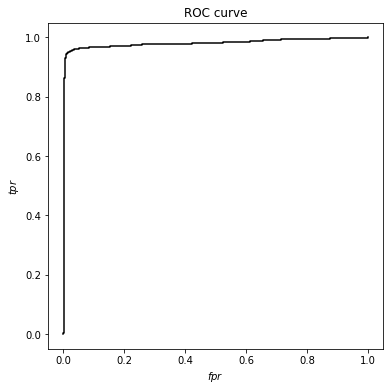

In [11]:
from sklearn.neural_network import MLPClassifier
    
clf_nn = MLPClassifier(hidden_layer_sizes=(5),solver='sgd',activation='logistic', # grad descent solver and sigmoid activation funct
                       learning_rate='constant', learning_rate_init=0.001,
                       random_state=1, max_iter=5000)

clf_nn.fit(Xtrain_scaled, y_train)

# Look at the weights
print([coef.shape for coef in clf_nn.coefs_])

y_pred = clf_nn.predict(Xtest_scaled)

# accuracy of the classifier
accuracy = accuracy_score(y_test,y_pred)
print('accuracy:',accuracy)

proba = clf_nn.predict_proba(Xtest_scaled)[:,1]
fpr, tpr, thresh = roc_curve(y_test, proba)

fig = plt.figure(figsize=(6,6))

plt.plot(fpr, tpr,color='black')
plt.xlabel(r'$fpr$')
plt.ylabel(r'$tpr$')
plt.title('ROC curve')

plt.show()

### Cross-validation to determine the best number of layers and the best learning rate

In [19]:
n_layers = np.array([np.arange(1,5),np.arange(1,5)])
n_layers

array([[1, 2, 3, 4],
       [1, 2, 3, 4]])

In [22]:
# define the NN classifier
clf_grid = MLPClassifier(solver='sgd',activation='logistic',learning_rate='constant',
            random_state=1, max_iter=5000)

# define the grid of layers and learning rates:
n_layers = np.arange(1,11)
learn_rates = np.linspace(0.0001,0.01,10)
solver_arr = np.array(['lbfgs', 'sgd', 'adam'])
activation_arr = np.array(['identity', 'logistic', 'tanh', 'relu'])
l_rate = np.array(['constant','adaptive']) 

grid = GridSearchCV(clf_grid, param_grid={'hidden_layer_sizes': n_layers, 'learning_rate_init':learn_rates,
                                          'solver': solver_arr, 'activation': activation_arr,
                                          'learning_rate': l_rate}, cv=5, n_jobs=-1) 

grid.fit(Xtrain_scaled,y_train)
 

best N_layers: 10
best learning raee: 0.0089


In [24]:
best_rate = grid.best_params_['learning_rate_init']
best_layer = grid.best_params_['hidden_layer_sizes']     
best_solver = grid.best_params_['solver']
best_activation = grid.best_params_['activation']
best_learn_rate = grid.best_params_['learning_rate']

print('best N_layers:',best_layer)
print('best learning rate:',best_rate)
print('best solver:',best_solver)
print('best activation function:',best_activation)
print('best learning method:',best_learn_rate)


best N_layers: 10
best learning rate: 0.0089
best solver: adam
best activation function: tanh
best learning method: constant


[(4, 10), (10, 1)]
accuracy cross_validated: 0.9848666666666667
accuracy basic NN: 0.9840666666666666


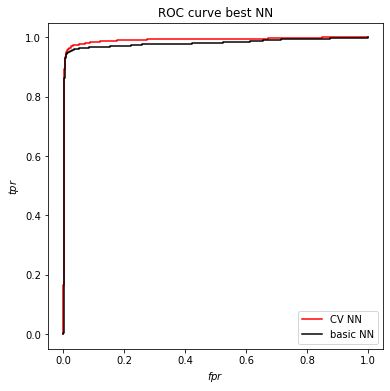

In [25]:
clf_best = MLPClassifier(hidden_layer_sizes=(best_layer),solver=best_solver,activation=best_activation,
                       learning_rate=best_learn_rate, learning_rate_init=best_rate,
                       random_state=1, max_iter=5000)

clf_best.fit(Xtrain_scaled, y_train)

# Look at the weights
print([coef.shape for coef in clf_best.coefs_])

y_pred_best = clf_best.predict(Xtest_scaled)

# accuracy of the classifier
accuracy_best = accuracy_score(y_test,y_pred_best)
print('accuracy cross_validated:',accuracy_best)
print('accuracy basic NN:',accuracy)

proba_best = clf_best.predict_proba(Xtest_scaled)[:,1]
fpr_best, tpr_best, thresh_best = roc_curve(y_test, proba_best)

fig = plt.figure(figsize=(6,6))

plt.plot(fpr_best, tpr_best,color='red',label='CV NN')
plt.plot(fpr,tpr,color='black',label='basic NN')
plt.xlabel(r'$fpr$')
plt.ylabel(r'$tpr$')
plt.title('ROC curve best NN')
plt.legend()
plt.show()

# Stufff

In [58]:
def error_func(y_true, y_m):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2)) 

def cross_validation(X,y,model,split_method):
    "computes and returns the cross validation error and the training error, given the datasets and the model to validate"
    
    split = split_method # sample splitting
    
    err_train_i = []
    err_cv_i = []
    
    # iterating over the n_splits
    for train, test in split.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_true_train = y[train]
        
        y_cv = model.predict(X[test])
        y_true_cv = y[test]
    
        # compute the errors on the training and cross-validation set for a given set
        err_train_i.append(error_func(y_true_train,y_train)) # compute the error on the training set
        err_cv_i.append(error_func(y_true_cv,y_cv)) # compute the error on the validation set
   
    err_train = np.mean(err_train_i)
    err_cv = np.mean(err_cv_i)
    
    return err_train, err_cv

In [ ]:
n_layers = np.arange(2,20)

rms_val = np.zeros(len(n_layers))
rms_train = np.zeros(len(n_layers))

for n in n_layers:
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = MLPClassifier(hidden_layer_sizes=(n),solver='sgd',activation='logistic', # grad descent solver and sigmoid activation funct
                           learning_rate='constant', learning_rate_init=0.001,
                           random_state=1, max_iter=5000)
    
    rms_train[n-2],rms_val[n-2] = cross_validation(Xtrain_scaled,y_train,model,split_method)

best_Nlayers = n_layers[np.argmin(rms_val)]
print(best_Nlayers)

fig = plt.figure(figsize=(7,7))

plt.plot(n_layers,rms_val,label='validation',color='red')
plt.plot(n_layers,rms_train,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('$N_{layers}$')
plt.title('Best N-layers cross-validation')
plt.legend()